In [64]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
from IPython.display import display_html 
import pandas as pd



# Initialization

In [2]:
def initialize(spin, hl):

    CASE=1
    if CASE==0: dname="DATA"
    if CASE==1: dname="DATA_b"
        
    fname=dname+'/x_RBM_q0.1.dat'
    # loading data: each row is a list of visible units
    # NOTE: data "x" here is named "v" for "visible"
    v = np.loadtxt(fname, delimiter=" ",dtype=int)
    #v = v[0:500]
    # store in v0, because later we will shuffle v
    v0 = np.copy(v)
    # to start, take a small subsample
    # v = v[1:11]
    N = len(v)
    L = len(v[1])


    SPINS = spin
    #SPINS = False

    if SPINS:
        # sigmoid takes into account energy difference =2
        GAP=2
        # convert 0,1 -> -1,1
        v = 2*v - 1
        vmin=-1
        vv = [[1,-1,-1,-1], [-1,1,-1,-1], [-1,-1,1,-1], [-1,-1,-1,1]]
        v0 = 2*v0 -1
    else:
        GAP=1
        vmin=0
        vv = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]


    print(f'each of N={N} data has L={L} digits')

    for i in range(min(12,N)):
        if SPINS: print(v0[i],"\n->",v[i])
        else: print(v[i])
    print('...')

    # RBM, nr of hidden units
    if CASE==0: M = 3
    if CASE==1: M = hl
    # range of each initial weight
    sigma = sqrt(4. / float(L + M))
    # random seed for reproducibility
    np.random.seed(12345)
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(L,M)
    a = sigma * np.random.randn(L)
    b = np.zeros(M)
    print("w=",w);print("a=",a);print("b=",b)
    w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)
    return w,a,b,w0,a0,b0,L,M,N,vv,GAP,vmin,v,v0,SPINS

## Plotting

In [3]:
L,M=20,2
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


# Energy and activation function 

In [4]:
def energy(h,a,b,wei): #return energy of the 4bit strings
    #print("IL VETTORE VV È PARI A",vv)
    #offset = np.array([0.25,0.25,0.25,0.25])
    #offset = np.zeros(4)
    #vv_off = vv - offset
    #E = [-np.dot(a,vv_off[i]) - np.dot(b,h) - np.dot(vv_off[i],np.matmul(wei,h)) for i in range(len(vv))]
    E = [-np.dot(a,vv[i]) - np.dot(b,h) - np.dot(vv[i],np.matmul(wei,h)) for i in range(len(vv))]
    return E

# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    

    return v_out

def activate_ohe(v_in,h,wei,a,b,DE, info=False, backward=False): #activate for one hot encoding
    if(backward==False):
        act = np.dot(v_in, wei) + b
        n = np.shape(act)
        prob = 1. / (1. + exp(-DE*act))
        v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's

        #print("n:",n)
        #print("vmin:",vmin)
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)

        return v_out #it's hidden variable
    else:
        v_out = []
        for j in range(5):
            a1 = [a[i:i + 4] for i in range(0, len(a), 4)]
            w1 = [w[i:i + 4,:] for i in range(0, len(a), 4)]
            E = np.array(energy(h,a1[j],b,w1[j]))
            #print("E", E)
            p = np.exp(-E)/np.sum(np.exp(-E))
            #print("p", p)
            v_out.append(vv[int(np.random.choice([0,1,2,3], 1, p=p))])
        return np.ravel(v_out)
        

#k = 0
#activate(v[k],w,b,GAP,info=True)

# Update Algorithm

In [19]:
def SGD(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b,l_rate_m):
    dw = l_rate_m*(vh_data - vh_model)
    da = l_rate_m*(v_data - v_model)
    db = l_rate_m*(h_data - h_model)
    #if epoch<=1 and k<=mini:
    #    print('----------- epoch =',epoch,'  k=',k,'  m=',m)
    #    print('dw =',dw)
    #    print('da =',da)
    #    print('db =',db)
    # basic step of vanilla gradient descent, from eq.(211)
    w = w + dw
    a = a + da
    b = b + db
    return w,a,b

def centered_SGD(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b,l_rate_m):
    dw = l_rate_m*(vh_data - vh_model)
    da = l_rate_m*(v_data - v_model - np.matmul(dw,lam))
    db = l_rate_m*(h_data - h_model - np.matmul(dw.T,mu))
    #if epoch<=1 and k<=mini:
    #    print('----------- epoch =',epoch,'  k=',k,'  m=',m)
    #    print('dw =',dw)
    #    print('da =',da)
    #    print('db =',db)
    # basic step of vanilla gradient descent, from eq.(211)
    w = w + dw
    a = a + da
    b = b + db
    return w,a,b


def ADAM(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b, l_rate_m, t, mw, ma, mb, sw, sa, sb,center=False): #or RMS
        Beta1 = 0.9
        Beta2 = 0.99
        epsilon = 1.e-8
        #epsilon = 0.1
        
        if(center==False):
            dw = (vh_data - vh_model)
            da = (v_data - v_model)
            db = (h_data - h_model)
        else:
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model - np.matmul(dw,lam))
            db = l_rate_m*(h_data - h_model - np.matmul(dw.T,mu))

        mw = Beta1*mw + (1 - Beta1)*dw
        ma = Beta1*ma + (1 - Beta1)*da
        mb = Beta1*mb + (1 - Beta1)*db

        sw = Beta2*sw + (1 - Beta2)*(dw**2)
        sa = Beta2*sa + (1 - Beta2)*(da**2)
        sb = Beta2*sb + (1 - Beta2)*(db**2)

        mhat_w = (1 / (1 - np.power(Beta1,t)) ) * mw
        mhat_a = (1 / (1 - np.power(Beta1,t)) ) * ma
        mhat_b = (1 / (1 - np.power(Beta1,t)) ) * mb

        shat_w = (1 / (1 - np.power(Beta2,t)) ) * sw
        shat_a = (1 / (1 - np.power(Beta2,t)) ) * sa 
        shat_b = (1 / (1 - np.power(Beta2,t)) ) * sb

#        w = w - l_rate_m*mhat_w/ np.sqrt(np.sqrt(np.linalg.det(np.matmul(shat_w, shat_w.T))) + epsilon)
        w = w + l_rate_m*mhat_w/ (np.sqrt(shat_w) + epsilon)
        a = a + l_rate_m*mhat_a/ (np.sqrt(shat_a) + epsilon)
        b = b + l_rate_m*mhat_b/ (np.sqrt(shat_b) + epsilon)

        return w,a,b, mw, ma, mb, sw, sa, sb

In [6]:
def check_structure(v,vv):
    #print(v)
    def polar(w):
        w = list(w)
        if((w==vv[0]) or (w==vv[1])) :
            return True
        else:
            return False
    
    counts = 0
    #print("len v", len(v))
    for i in range(0,len(v)-4,4):
        if polar(v[i:i+4]):
            if polar(v[i+4:i+8]):
                counts += 1
        else:
            if polar(v[i+4:i+8])==False :
                counts += 1
                
    return counts
                

# Energy Plot

In [7]:
def Average_energy(v0,h,w,a,b):
    E = np.mean([(-np.dot(a,v0[k]) - np.dot(b,h[k]) - np.dot(v0[k],np.matmul(w,h[k])))for k in range(len(v0))])
    #Beta equal to 1
    #Z = 0
    #if GAP==2:
    #    h_values = [-1,1]
    #else: h_values = [0,1]
        
    #for H in h_values:
    #    Z += np.sum(energy(H,a,b,w))
    #Z = np.cumsum([np.exp(-(-np.dot(a,v0[k]) - np.dot(b,h) - np.dot(v0[k],np.matmul(w,h)))) for k in range(len(v0))])
    #logLike = np.log((1/Z[len(Z)-1])*np.exp(-E))
    return E
def En_plot(E_d,E_m):
    fig, (axE, axdiffE) = plt.subplots(2, 1 , figsize=(10, 5))
    axE.plot([i for i in range(len(E_d))], E_d, label = "Energy from Data")
    axE.plot([i for i in range(len(E_m))], E_m, label = "Energy from Model")
    axdiffE.plot([i for i in range(len(E_m))], np.array(E_d) - np.array(E_m), label = "Edata - Emodel")
    axE.set_xlabel("epochs")
    axE.set_ylabel("Energy")
    axE.legend(loc = 'best')
    axdiffE.set_xlabel("epochs")
    axdiffE.set_ylabel("\u0394 Energy")
    axdiffE.legend(loc = 'best')

def LL(Edata,a,b,wei):
    Z = 0
    for hh in [[vmin],[1]]:
        for i1 in range(4):
            for i2 in range(4):
                for i3 in range(4):
                    for i4 in range(4):
                        for i5 in range(4):
                            vvv = []
                            vvv.append(vv[i1])
                            vvv.append(vv[i2])
                            vvv.append(vv[i3])
                            vvv.append(vv[i4])
                            vvv.append(vv[i5])
                            vvv = np.ravel(vvv)
                            wei = np.array(wei)
                            Z += np.exp(-(-np.dot(a,vvv) - np.dot(b,hh) - np.dot(vvv,np.matmul(wei,hh))))

                        
    return (-Edata - np.log(Z))


# Test noise reduction

In [8]:
def test_noise(amplitude,vv,v0,h,w,a,b,GAP,fname,SPIN):
    
    ampl=amplitude
    # original, non-reshuffled data in v0
    h=0
    v1 = np.zeros_like(v0)
    for k in range(N):
        # positive CD phase: generating h 
        h = activate_ohe(v0[k],h,w,a,b,ampl*GAP)
        # negative CD phase: generating fantasy vf with low T == large GAP
        v1[k] = activate_ohe(v0[k],h,w,a,b,ampl*GAP,backward=True)
    # difference between fantasy and data
    diff = (v1 - v0)/2
    str0 = fname+'_M'+str(M)+'-mini'+str(mini)
    np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
    np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  
    #print("number of errors in pol-nonpol of RBM genereted data",check_structure(v1,vv))

    def is_one(cell_value):
        color0 = 'background-color: gray; color: white'
        color1 = 'background-color: gold;'
        if type(cell_value) in [float, int]:
            if cell_value == 1:
                return color1
        return color0

    N1=12
    df0 = pd.DataFrame(v0[:N1])
    df1 = pd.DataFrame(((v1[:N1])).astype(int))

    df0s = df0.style.set_table_attributes("style='display:inline'")
    df1s = df1.style.set_table_attributes("style='display:inline'")
    df0s.applymap(is_one)
    df1s.applymap(is_one)
    sty = [dict(selector="caption",props=[("font-size", "150%")])]
    df0s.set_caption('Original').set_table_styles(sty)
    df1s.set_caption('Denoised').set_table_styles(sty)

    display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
    
    
    #if SPIN==True:
    #    v0 = (v0 +1)/2
    c0 = 0
    c = 0
    for i in range(len(v)):
        c0 += check_structure(v0[i],vv)
        c += check_structure(v1[i],vv)
    print("number of errors in pol-nonpol of real data", c0)
    print("number of errors in pol-nonpol of RBM generated data", c)



In [11]:
import time

In [12]:
def calculate_v1(v0, a, b, w, GAP):
    # original, non-reshuffled data in v0
    h=0
    h_m = []
    hf_m = []
    v_m = []
    v1 = np.zeros_like(v0)
    for k in range(N):
        # positive CD phase: generating h 
        h = activate_ohe(v0[k],h,w,a,b,GAP)
        # negative CD phase: generating fantasy vf with low T == large GAP
        v1[k] = activate_ohe(v0[k],h,w,a,b,GAP,backward=True)
        hf = activate_ohe(v0[k],h,w,a,b,GAP)
        h_m.append(h)
        hf_m.append(hf)


    # compute the second momentum between fantasy and data
    v1 = ((v1-vmin)/(1-vmin)).astype(int)

    return v1, h_m, hf_m


def moment_2(v0, v1):
    
    v1 = np.array(v1)
    
    Nv = len(v0[0])
    Ns = len(v0[:,0])

    Cij_mse = 0
    
    for j in range(1, Nv):
        for i in range(j):
            Cij_D = 0
            Cij_RBM = 0
            mi_D = np.mean(v0[:, i])
            mj_D = np.mean(v0[:, j])
            mi_RBM = np.mean(v1[:, i])
            mj_RBM = np.mean(v1[:, j])
            for n in range(len(v0[:, 0])):
                Cij_D += (v0[n][i] - mi_D)*(v0[n][j] - mj_D)*(1/Ns)
                Cij_RBM += (v1[n][i] - mi_RBM)*(v1[n][j] - mj_RBM)*(1/Ns)
            Cij_mse += (Cij_D - Cij_RBM)**2
    moment_2 = 2*Cij_mse/(Nv*(Nv-1))
    return moment_2




# Without Centering trick

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
w= [[-0.08934175]
 [ 0.20902801]
 [-0.22670164]
 [-0.24254059]
 [ 0.85793698]
 [ 0.60813216]
 [ 0.04054832]
 [ 0.1229641 ]
 [ 0.33562896]
 [ 0.54398872]
 [ 0.43957347]
 [-0.56571727]
 [ 0.12001619]
 [ 0.09990577]
 [ 0.59046131]
 [ 0.38686948]
 [-0.87358614]
 [-0.16228539]
 [ 0.72842236]
 [-0.19140752]]
a= [-2.35562479e-01  2.08173325e-01  1.41795538e+00 -4.45700232e-01
 -2.51861548e-01  5.41709658e-02  1.32071386e-01  2.28592871e-01
  4.10370865e-04  

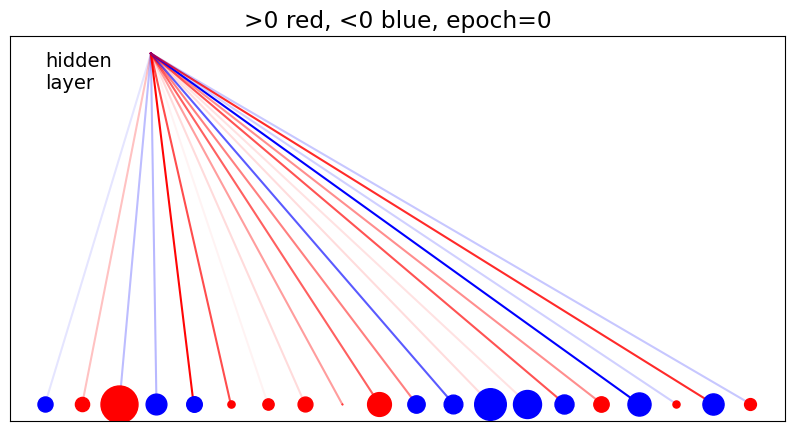

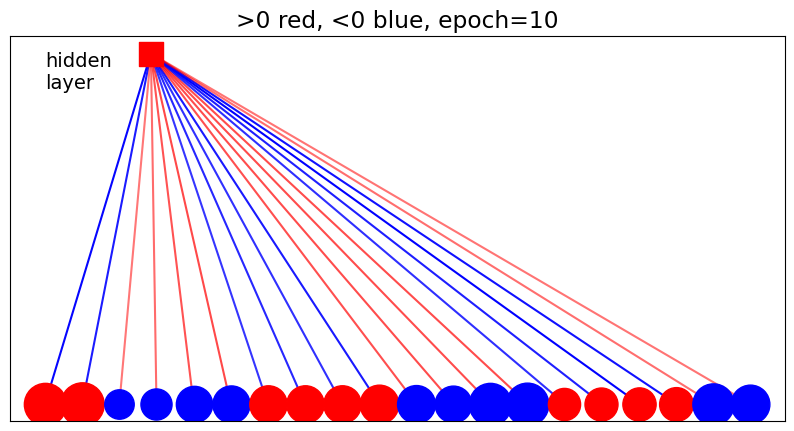

l_rate =  0.009990009990009995


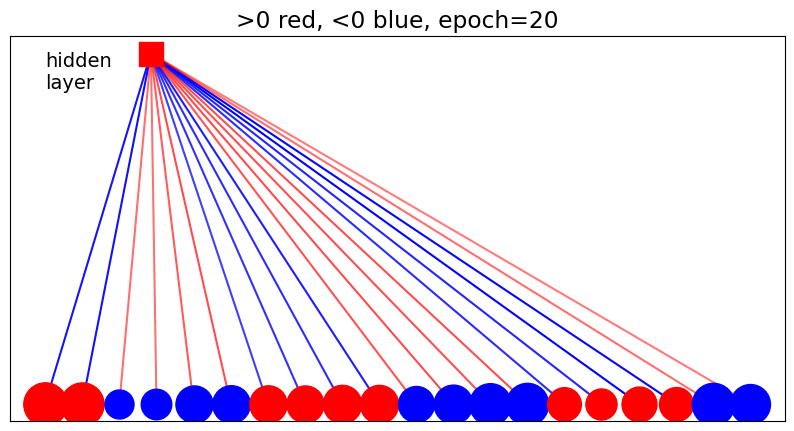

l_rate =  0.009980039920159686


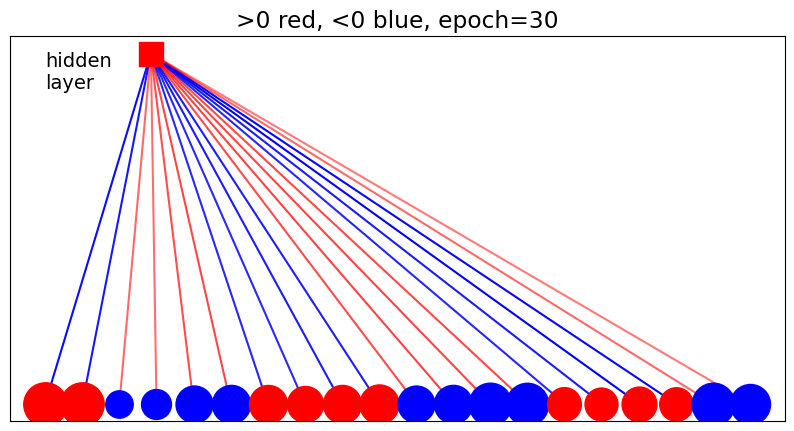

l_rate =  0.009970089730807583


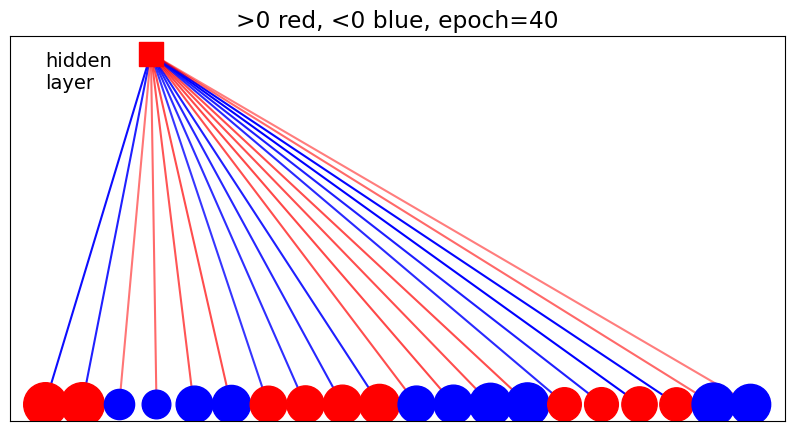

l_rate =  0.009960159362549804


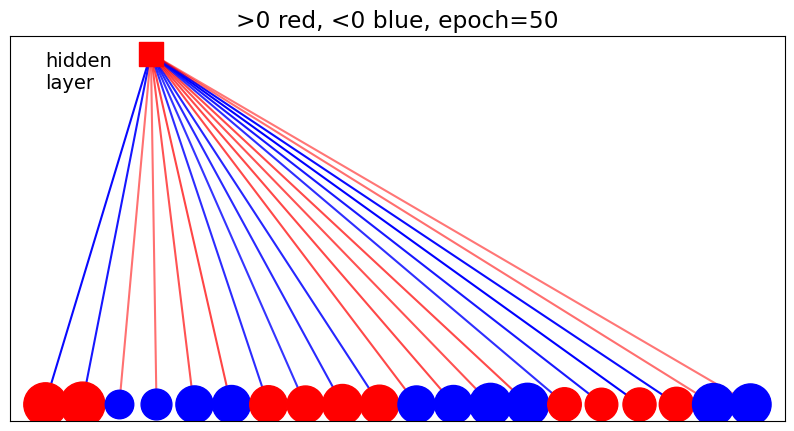

l_rate =  0.009950248756218907


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


number of errors in pol-nonpol of real data 3783
number of errors in pol-nonpol of RBM generated data 3629


In [59]:
#start = timer()

w,a,b,w0,a0,b0,L,M,N,vv,GAP,vmin,v,v0,SPINS = initialize(spin=False, hl=1)

# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

h=0

#additional iterations for contrastive divergence
iterations = 0

# learning rate
l_rate = 0.01

#offsets
lam, mu = np.zeros(M), np.zeros(L)

#moving average factors
xi_lam, xi_mu = 0.01, 0.01


# minibatch
mini, m = 100, 0

E_d, E_m = [], []
epochss = 50
Ed_wc, Em_wc, diffE_wc = [], [], []

# second_momentum ini 
momentum2_SGD_spins = np.zeros(epochss)
LogL_mwc = []
EADAM_d, EADAM_m = [], []



# train model
print('===================================================')
for epoch in range(epochss):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate
    mw, ma, mb, sw, sa, sb= 0, 0, 0, 0, 0, 0
    t = 0 

    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate_ohe(v[k],h,w,a,b,GAP)
        #if(k==1): print("i valori di h sono",h)

        # negative CD phase: generating fantasy vf
        vf = activate_ohe(v[k],h,w,a,b,GAP,backward=True)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = activate_ohe(vf,h,w,a,b,GAP)
        #print("vv is ",vv)
        for j in range(iterations):
            vf = activate_ohe(vf,hf,w,a,b,GAP,backward=True)
            hf = activate_ohe(vf,hf,w,a,b,GAP)
            
        
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h) 
        vh_model+= np.outer(vf.T,hf) 

        
        m += 1
        #print("k", k)
        # minibatch
        if m==mini:
            t +=1

            #upgrading biases
            v_data = v_data/mini
            v_model = v_model/mini

            h_data  = h_data/mini
            h_model = h_model/mini
            
            vh_data = vh_data/mini
            vh_model = vh_model/mini

            #a = a + xi_lam * np.matmul(w, (h_data-lam))
            #b = b + xi_mu * np.matmul(w.T, (v_data-mu))
            #upgrading offsets
            #mu = (1-xi_mu)*mu + xi_mu * v_data
            #lam = (1-xi_lam)*lam + xi_lam * h_data
            
            w, a, b, mw, ma, mb, sw, sa, sb= ADAM(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b, l_rate_m, epoch*int(N/mini)+t, mw, ma, mb, sw, sa, sb)
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            m=0

    #momentum3_SGD_spins[epoch] = moment_3(v0, a, b, w, GAP)
    v1_m, h_m, hf_m = calculate_v1(v0,a,b,w,GAP)
    #print(v1)
    #momentum2_SGD_100[epoch] = moment_2(v0, v1_m)
    ESGD_data = Average_energy(v0,h_m, w, a, b)
    ESGD_model = Average_energy(v1_m,hf_m, w, a, b)
    Ed_wc.append(ESGD_data)
    Em_wc.append(ESGD_model)
    LogL = LL(ESGD_data,a,b,w)
    LogL_mwc.append(LogL)

    #print("epoca:", epoch)
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)#print('w0=',w0);print('a0=',a0);print('b0=',b0)

        
#end = timer()
#print("time:", end - start)
        
#En_plot(E_d, E_m)
#print('w=',w);print('a=',a);print('b=',b)
test_noise(40,vv,v0,h,w,a,b,GAP, fname='DATA_b'+'/x_RBM_q0.1.dat',SPIN=SPINS)

# Centered gradient

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
w= [[-0.08934175]
 [ 0.20902801]
 [-0.22670164]
 [-0.24254059]
 [ 0.85793698]
 [ 0.60813216]
 [ 0.04054832]
 [ 0.1229641 ]
 [ 0.33562896]
 [ 0.54398872]
 [ 0.43957347]
 [-0.56571727]
 [ 0.12001619]
 [ 0.09990577]
 [ 0.59046131]
 [ 0.38686948]
 [-0.87358614]
 [-0.16228539]
 [ 0.72842236]
 [-0.19140752]]
a= [-2.35562479e-01  2.08173325e-01  1.41795538e+00 -4.45700232e-01
 -2.51861548e-01  5.41709658e-02  1.32071386e-01  2.28592871e-01
  4.10370865e-04  

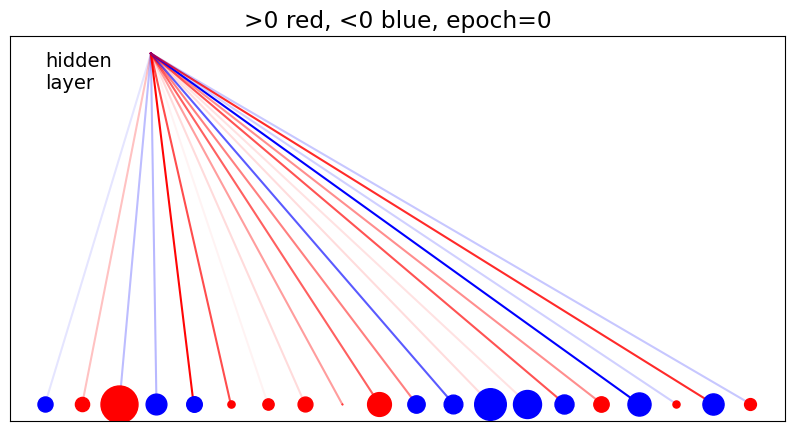

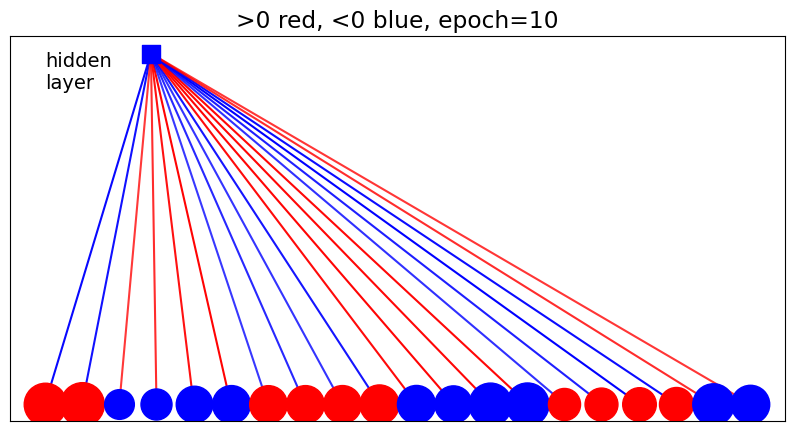

l_rate =  0.009990009990009995


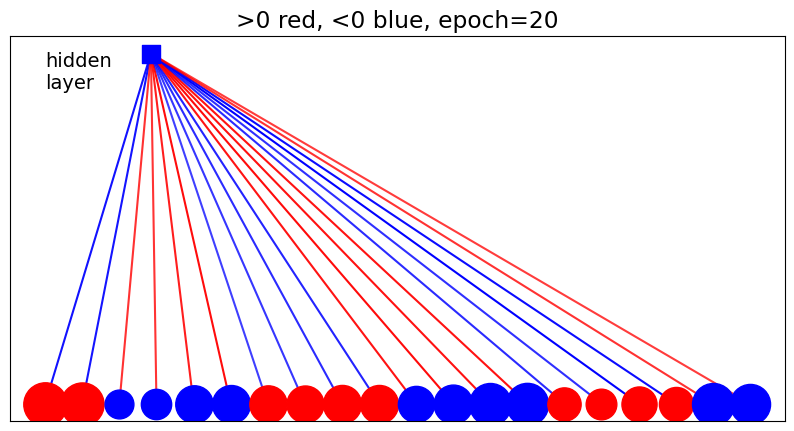

l_rate =  0.009980039920159686


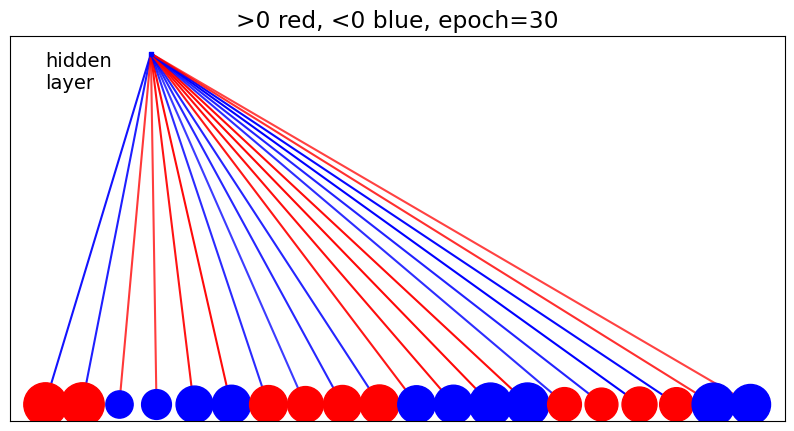

l_rate =  0.009970089730807583


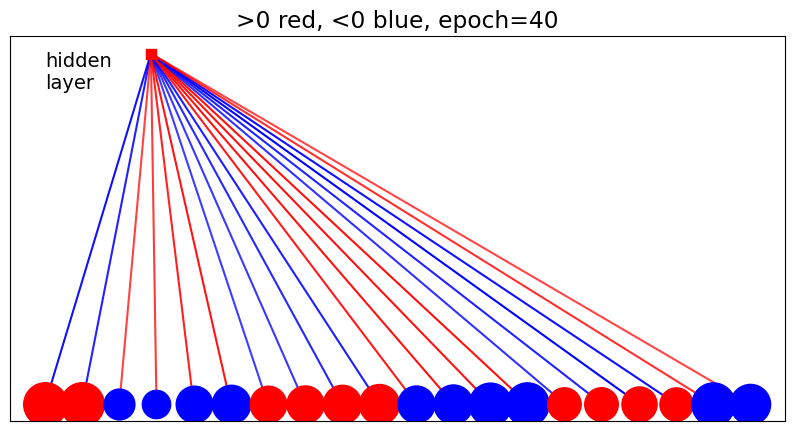

l_rate =  0.009960159362549804


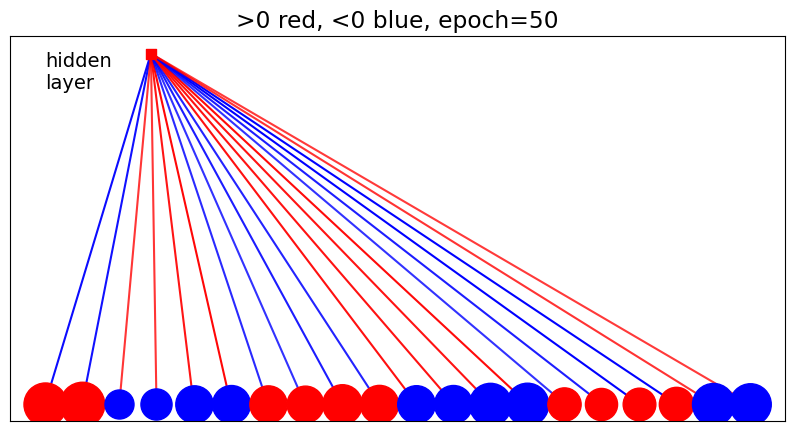

l_rate =  0.009950248756218907


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


number of errors in pol-nonpol of real data 3783
number of errors in pol-nonpol of RBM generated data 3629


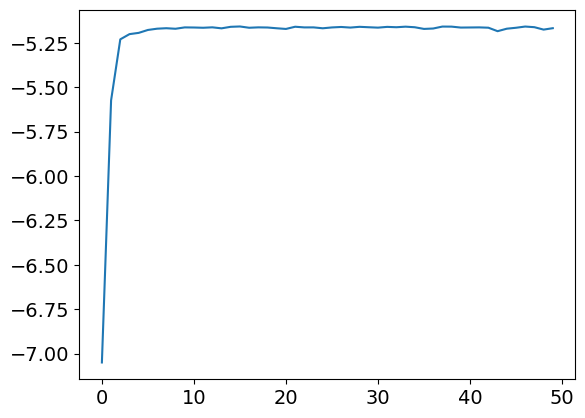

In [60]:
#start = timer()

w,a,b,w0,a0,b0,L,M,N,vv,GAP,vmin,v,v0,SPINS = initialize(spin=False, hl=1)

# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

h=0

#additional iterations for contrastive divergence
iterations = 0

# learning rate
l_rate = 0.01

#offsets
lam, mu = np.zeros(M), np.zeros(L)

#moving average factors
xi_lam, xi_mu = 0.01, 0.01


# minibatch
mini, m = 100, 0

E_d, E_m = [], []
epochss = 50

# second_momentum ini 
momentum2_SGD_spins = np.zeros(epochss)
Ed_c, Em_c, diffE_c = [], [], []

LogL_mc = []


# train model
print('===================================================')
for epoch in range(epochss):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate
    mw, ma, mb, sw, sa, sb= 0, 0, 0, 0, 0, 0
    t = 0 
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate_ohe(v[k],h,w,a,b,GAP)
        #if(k==1): print("i valori di h sono",h)

        # negative CD phase: generating fantasy vf
        vf = activate_ohe(v[k],h,w,a,b,GAP,backward=True)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = activate_ohe(vf,h,w,a,b,GAP)
        #print("vv is ",vv)
        for j in range(iterations):
            vf = activate_ohe(vf,hf,w,a,b,GAP,backward=True)
            hf = activate_ohe(vf,hf,w,a,b,GAP)
            
        
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        #vh_data += np.outer(v[k].T,h) 
        #vh_model+= np.outer(vf.T,hf) 
        vh_data += np.outer(v[k].T - mu.T , h - lam) 
        vh_model+= np.outer(vf.T - mu.T , hf - lam) 
        
        m += 1
        #print("k", k)
        # minibatch
        
        if m==mini:
            t+=1
            #upgrading biases
            v_data = v_data/mini
            v_model = v_model/mini

            h_data  = h_data/mini
            h_model = h_model/mini
            
            vh_data = vh_data/mini
            vh_model = vh_model/mini

            #a = a + xi_lam * np.matmul(w, (h_data-lam))
            #b = b + xi_mu * np.matmul(w.T, (v_data-mu))
            #upgrading offsets
            mu = (1-xi_mu)*mu + xi_mu * v_data
            lam = (1-xi_lam)*lam + xi_lam * h_data
            
            w, a, b, mw, ma, mb, sw, sa, sb= ADAM(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b, l_rate_m, epoch*int(N/mini)+t, mw, ma, mb, sw, sa, sb, center=True)
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            m=0

     #v1 = calculate_v1(v0-mu,h-lam, a, b, w, GAP)
    #momentum2_SGD_spins[epoch] = moment_2(v1, v0, a, b, w, GAP)

    #momentum3_SGD_spins[epoch] = moment_3(v0, a, b, w, GAP)
    v1_m, h_m, hf_m = calculate_v1(v0,a,b,w,GAP)
    #print(v1)
    #momentum2_SGD_100[epoch] = moment_2(v0, v1_m)
    ESGD_data = Average_energy(v0,h_m, w, a, b)
    ESGD_model = Average_energy(v1_m,hf_m, w, a, b)
    Ed_c.append(ESGD_data)
    Em_c.append(ESGD_model)
    LogL = LL(ESGD_data,a,b,w)
    LogL_mc.append(LogL)

    #print("epoca:", epoch)
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)#print('w0=',w0);print('a0=',a0);print('b0=',b0)

        
#end = timer()
#print("time:", end - start)
        
#En_plot(E_d, E_m)
#print('w=',w);print('a=',a);print('b=',b)
test_noise(40,vv,v0,h,w,a,b,GAP, fname='DATA_b'+'/x_RBM_q0.1.dat',SPIN=SPINS)
plt.plot(range(len(LogL_mc)), LogL_mc)


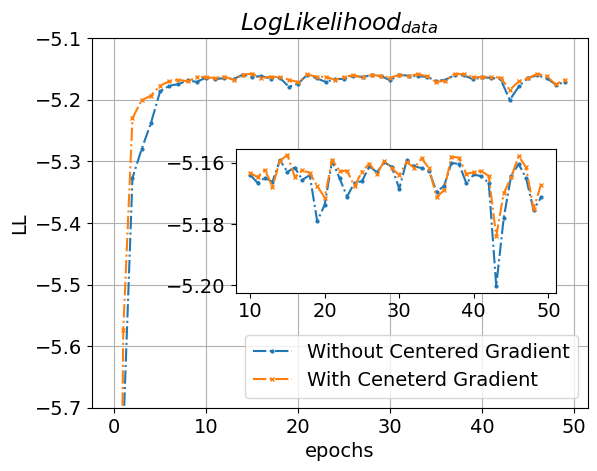

In [61]:
fig, axLL = plt.subplots()
axLL.plot([i for i in range(len(LogL_mwc))],LogL_mwc,"-.", marker= "o", markersize=2, label = "Without Centered Gradient")
axLL.plot([i for i in range(len(LogL_mc))], LogL_mc,"-.", marker= "x", markersize=3, label = "With Ceneterd Gradient")
axLL.set_xlabel("epochs")
axLL.set_ylabel("LL")
axLL.legend(loc = 'best')
axLL.set_title("$LogLikelihood_{data}$")
axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")
l, b, h, w = .35, .35, .3, .5
ax2 = fig.add_axes([l, b, w, h])
ax2.plot([i for i in range(10,len(LogL_mwc))],LogL_mwc[10:],"-.", marker= "o", markersize=2, label = "Without Centered Gradient")
ax2.plot([i for i in range(10,len(LogL_mc))], LogL_mc[10:],"-.", marker= "x", markersize=3, label = "With Ceneterd Gradient")
#ax2.legend(loc='upper left')


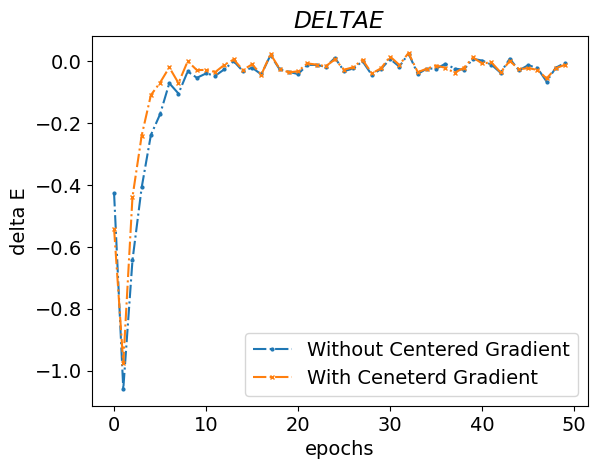

In [66]:
diffE_wc = np.array(Ed_wc) - np.array(Em_wc)
diffE_c = np.array(Ed_c) - np.array(Em_c)

fig, axE = plt.subplots()
axE.plot([i for i in range(len(diffE_wc))],diffE_wc,"-.", marker= "o", markersize=2, label = "Without Centered Gradient")
axE.plot([i for i in range(len(diffE_c))], diffE_c,"-.", marker= "x", markersize=3, label = "With Ceneterd Gradient")
axE.set_xlabel("epochs")
axE.set_ylabel("delta E")
axE.legend(loc = 'best')
axE.set_title("$DELTA E$")
#axE.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")




[0.018977313443506134, 0.017739228118704223]


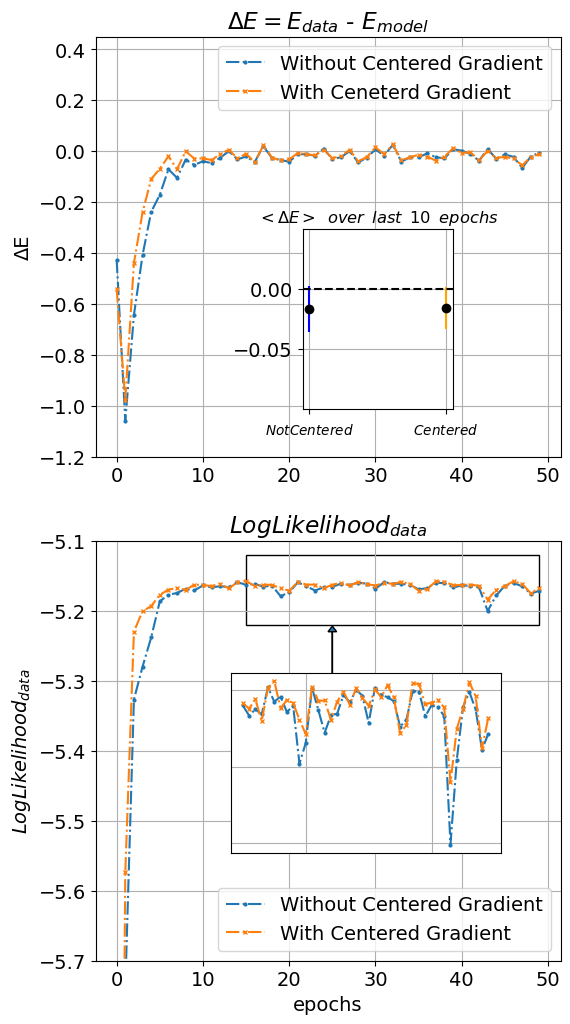

In [181]:
#diff_EADAM_500 = EADAM_d_500 - EADAM_m_500
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker


diffE_mean, diffE_std = [], []

diffE_mean.append(np.mean(diffE_wc[20:50]))
diffE_mean.append(np.mean(diffE_c[20:50]))

diffE_std.append(np.std(diffE_wc[20:50]))
diffE_std.append(np.std(diffE_c[20:50]))

algos = ["$_{Not Centered}$","$_{Centered}$"]
print(diffE_std)



fig, ( axdiffE, axLL) = plt.subplots(2, 1 , figsize=(6, 12))
axdiffE.plot([i for i in range(len(diffE_wc))], diffE_wc,"-.", marker= "o", markersize=2, label = "Without Centered Gradient")
axdiffE.plot([i for i in range(len(diffE_c))], diffE_c,"-.", marker= "x", markersize=3, label = "With Ceneterd Gradient")
#axdiffE.set_xlabel("epochs")
axdiffE.set_ylim(-1.2,0.45)
axdiffE.set_ylabel("\u0394E")
axdiffE.set_title("$\Delta E = E_{data}$ - $E_{model}$")
axdiffE.legend(loc = 'best')
#plt.ylim(-0.2,0.1)
axdiffE.grid(True, which= "both")
l, b, h, w = .47, .57, .15, .25
ax2 = fig.add_axes([l, b, w, h])
ax2.errorbar(algos, diffE_mean, yerr = diffE_std, fmt = 'o', capthick = 1, color = 'black', ecolor = ['blue', 'orange', 'green', 'red'])
ax2.axhline(y = 0, linestyle = '--', color = "black")
#ax2.set_xticks([])
ax2.set_yticks(np.arange(-0.1, 0.05, 0.025))
ax2.yaxis.set_major_locator(ticker.FixedLocator([-0.05,0.00]))
ax2.set_title("$_{<\u0394E>}$ $_{over}$ $_{last}$ $_{10}$ $_{epochs} $")
#ax2.tick_params(which='major', width=1.0)
ax2.grid(True, which= "major")
#ax2.legend(loc='upper left')

axLL.plot([i for i in range(len(LogL_mwc))],LogL_mwc,"-.", marker= "o", markersize=2, label = "Without Centered Gradient")
axLL.plot([i for i in range(len(LogL_mc))], LogL_mc,"-.", marker= "x", markersize=3, label = "With Centered Gradient")
axLL.set_xlabel("epochs")
axLL.set_ylabel("$LogLikelihood_{data}$")
axLL.legend(loc = 'best')
axLL.set_title("$LogLikelihood_{data}$")
axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")
l, b, h, w = .35, .2, .15, .45
ax3 = fig.add_axes([l, b, w, h])
ax3.plot([i for i in range(10,len(LogL_mwc))],LogL_mwc[10:],"-.", marker= "o", markersize=2, label = "Without Centered Gradient")
ax3.plot([i for i in range(10,len(LogL_mc))], LogL_mc[10:],"-.", marker= "x", markersize=3, label = "With Ceneterd Gradient")
ax3.grid(True, which= "both")
ax3.tick_params(left = False,labelleft = False ,
                           labelbottom = False, bottom = False)

#ax2.legend(loc='upper left')

# Create a Rectangle patch
rect = mpatches.Rectangle((15, -5.22), 34, 0.1, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the Axes
axLL.add_patch(rect)
axLL.arrow(25,-5.3,0,0.07,width=0.03,head_length=0.008, head_width=1)

plt.show()